# Problem Description

<center>![image](images/sleep_data_graph.PNG)</center>

My Garmin Vivosmart watch tracks the time I fall asleep and wake up each day using motion sensing and heart rate monitoring. To augment this data, I have estimated likelihoods that I am asleep based on the condition of my bedroom light (on/off) and if my phone is charging (yes/no). My objective is to use this data to create a model that returns the probability I am asleep at a given time. The final goal can be mathematically expressed as:

$$P(\text{sleep} | \text{time})$$.

In probability theory terms, this is the posterior probability I am asleep given the time. 

# Wake and Sleep Data Exploration

The wake and sleep data contains more than two months of information. The Garmin watch records when I fall asleep and wake up based on motion and heart rate. It is not 100% accurate as it often will think I'm sleeping if I turn off notifications and am quietly reading in bed. Sometimes we have to deal with imperfect data, and, because there are more truthful than false observations, we can expect the correct data to have a larger effect on the model. 

First, we will import the required libraries, and visualize both the sleep data and the waking data. 

In [2]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib
import arviz as az

import json
#s = json.load(open('../style/bmh_matplotlibrc.json'))
#matplotlib.rcParams.update(s)
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

In [3]:
# Data formatted in different notebook
sleep_data = pd.read_csv('data/sleep_data.csv')
wake_data = pd.read_csv('data/wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

In [5]:
wake_data.head()

,Unnamed: 0,indicator,time_offset
0,2017-12-01 05:00:00,1,-60
1,2017-12-01 05:01:00,1,-59
2,2017-12-01 05:02:00,1,-58
3,2017-12-01 05:03:00,1,-57
4,2017-12-01 05:04:00,1,-56


## Falling Asleep Data

Each dot represents one observation at a specific time with the color intensity corresponding to the number of points at that time. We can see that I tend to fall asleep a little after 10:00 PM. 

In [3]:
print('Number of sleep observations %d' % len(sleep_data))

Number of sleep observations 11340


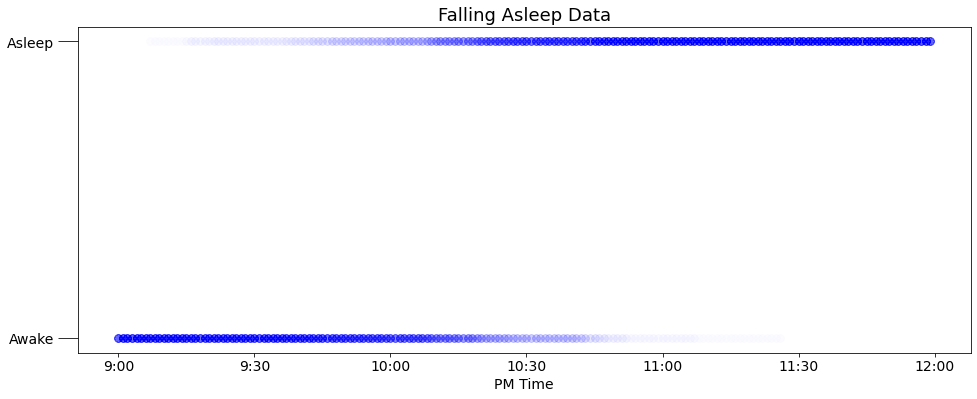

In [4]:
figsize(16, 6)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')

plt.yticks([0, 1], ['Awake', 'Asleep'])
plt.xlabel('PM Time')
plt.title('Falling Asleep Data', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

## Waking Up Data

My alarm is set for 6:00 AM every day of the week, and the wake data is more consistent than the sleep data. I nearly always wake up within a 10 minute window around 6:00 AM.

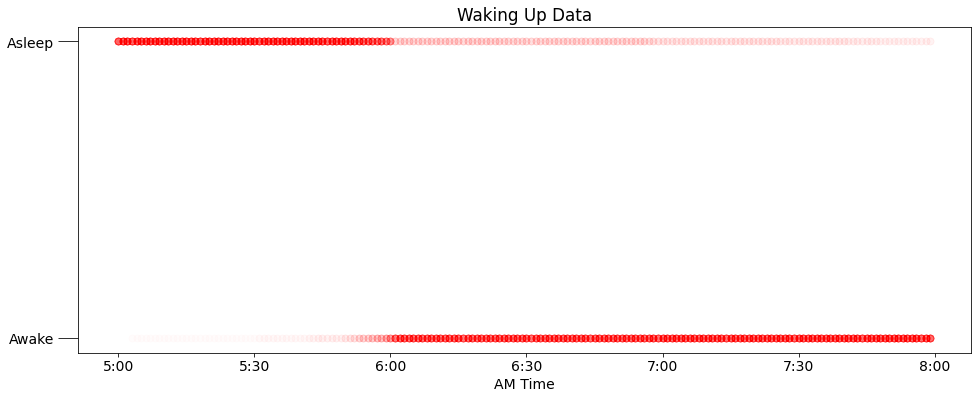

In [5]:
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r')

plt.yticks([0, 1], ['Awake', 'Asleep'])
plt.xlabel('AM Time')
plt.title('Waking Up Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

# Logistic Function to Represent Transition

We need to decide on a function to represent the transition from being awake to sleeping. There are a number of acceptable models, and here we will assume this transition can be modeled as a logistic function. A logistic function (also called a sigmoid) is a non-linear function bounded between 0 and 1. As ${t \to -\infty}, {p(s|t) \to 0}$ and, as ${t \to +\infty}, {p(s|t) \to 1}$. The expression for a logistic probability distribution for sleep as a function of time is:

$$p(s|t) = \frac{1}{ 1 + e^{\;\beta t } }$$

The $\beta$ parameter is unknown and be esimated using Markov Chain Monte Carlo sampling. MCMC samples from the prior for each parameter, trying to maximize the probabilty of the parameter given the data. 

Several logistic functions with various $\beta$ parameters are shown below:

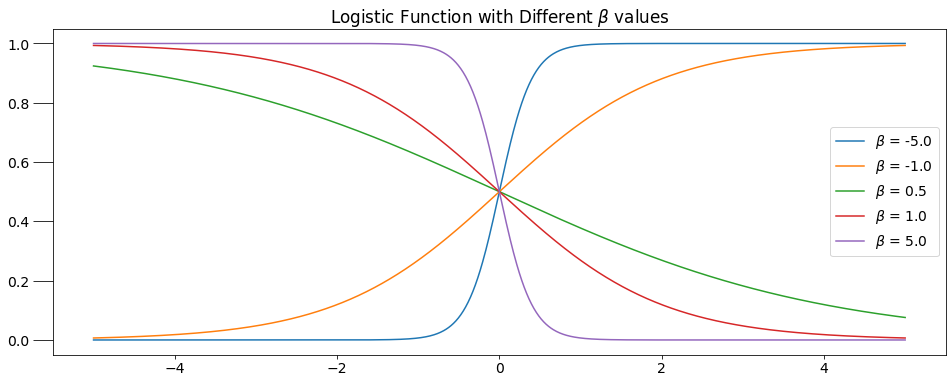

In [6]:
figsize(16, 6)

# Logistic function with only beta
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

# Plot examples with different betas 
x = np.linspace(-5, 5, 1000)

beta_list = [-5, -1, 0.5, 1, 5]

for beta in beta_list:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'Logistic Function with Different $\beta$ values');

There is one problem with the basic logistic function as shown above: the transition is centered at 0. However, in my sleeping data, the transition is around 10:00 pm for sleeping and 6:00 am for waking. We address this by adding an offset, called a bias, to adjust the location of the logistic function. The logistic function now is:

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$

This introduces another unknown parameter, $\alpha$, which we will also find from Markov Chain Monte Carlo.

The logistic function with various $\alpha$ and $\beta$ parameters is shown below.

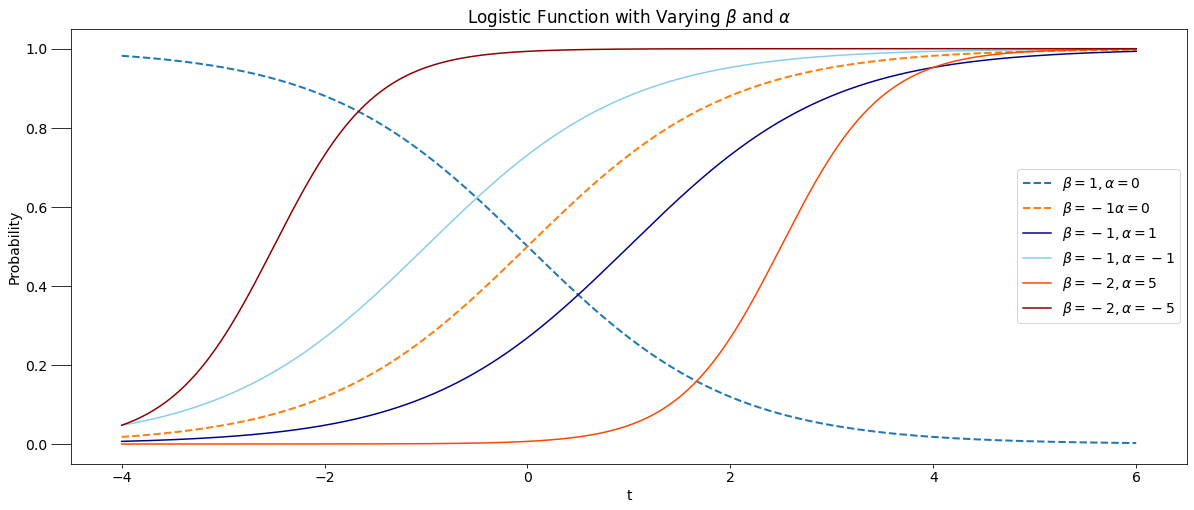

In [7]:
figsize(20, 8)

# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

# Plot examples of logistic regression with different alphas and betas
x = np.linspace(-4, 6, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1, \alpha = 0$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1 \alpha = 0$", ls="--", lw=2)

plt.plot(x, logistic(x, -1, 1), 
         label=r"$\beta = -1, \alpha = 1$", color="darkblue")

plt.plot(x, logistic(x, -1, -1),
         label=r"$\beta = -1, \alpha = -1$",color="skyblue")

plt.plot(x, logistic(x, -2, 5), 
         label=r"$\beta = -2, \alpha = 5$", color="orangered")

plt.plot(x, logistic(x, -2, -5), 
         label=r"$\beta = -2, \alpha = -5$", color="darkred")

plt.legend()
plt.ylabel('Probability')
plt.xlabel('t')
plt.title(r'Logistic Function with Varying $\beta$ and $\alpha$');

$\beta$ shifts the direction and steepness of the curve, while $\alpha$ changes the location. We will use MCMC to find the most likely value of these parameters under the data. 

# Prior Distribution for $\beta$ and $\alpha$

We have no evidence to suggest what the prior distributions for the model parameters $\beta$ and $\alpha$ are ahead of time. Therefore, we can model them as if they came from a normal distribution. The normal, or Gaussian, distribution is defined by the mean, $\mu$, and the precision, $\tau$. The precision is the reciprocal of the variance, $\sigma^2$. The mean defines the location of the distribution and the precision shows the spread. A larger value of $\tau$ indicates the data is less spread out (it is more precise) and hence the variation is smaller. The mean can be either positive or negative, but the precision will always be positive. A normal distribution as defined here is represented as:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

Probability density functions for three normal distributions are shown below.

More information on some of the functions 

- ``` stats.norm ``` https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- ``` zip() ``` https://www.w3schools.com/python/ref_func_zip.asp

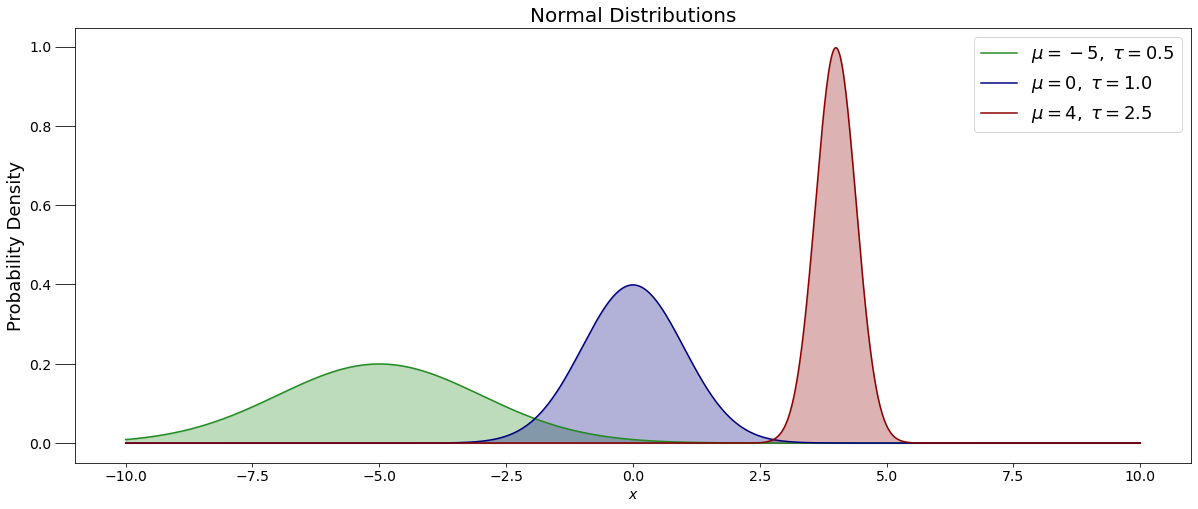

In [8]:
figsize(20, 8)

# Set up the plotting parameters
# nor = stats.norm  # Define a class with to 'host' A normal continuous random variable

x= np.linspace(-10, 10, 1000) # define 1000 equally spaced points between -10 and 10 
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5) # three parameters
colors = ("forestgreen", "navy", "darkred") # setting colours in a tuple



params = zip(mu, tau, colors)
# returns a zip object, which is an iterator of tuples where the first item
# in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc


# Plot 3 pdfs for different normal distributions
for param in params:
    
    y = stats.norm.pdf(x, loc = param[0], scale = 1 / param[1]) # draws pdf for each mu and tau - sets it to y
    
    # Plotting function 3 distributions (y pdfs) - plot y pdf against the space x
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]),  # label each plot
             color = param[2]) # colour each plot differently
    
    plt.fill_between(x, y, color = param[2], alpha = 0.3) # fill plots with lighter colour (alpha transperancy)
    
plt.legend(prop={'size':18}); # add legend of size 18
plt.xlabel("$x$")  
plt.ylabel("Probability Density", size = 18)
plt.title("Normal Distributions", size = 20);

## Parameter Search Space 

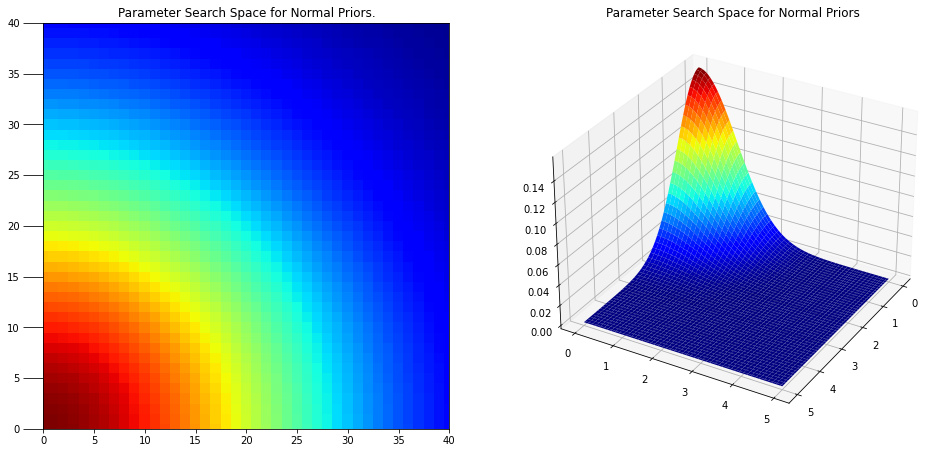

In [9]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# jet is a matlab colour schemde 
jet = plt.cm.jet
fig = plt.figure()

x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1)
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Parameter Search Space for Normal Priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("Parameter Search Space for Normal Priors");

The expected value of a normal distribution is the mean. 
$$ E[ X | \mu, \tau] = \mu$$ 

The variance of a normal distribution is equal to:

$$ Var[ X | \mu, \tau) = \frac{1}{\tau}$$

Again, we have no assumptions about the value for either $\mu$ or $\tau$ in the prior distributions for $\alpha$ and $\beta$. When we initialize the model, we can use $\mu = 0$ and a relatively large variance such as $\tau = 0.05$. Markov Chain Monte Carlo will sample values of $\mu$ and $\tau$ that try to maximize the likelihood of $\alpha$ and $\beta$ under the data.

## Markov Chain Monte Carlo

Markov Chain Monte Carlo will sample both $\beta$ and $\alpha$ from two normal distributions to find the parameters. Each iteration (state), an estimate for both $\beta$ and $\alpha$ are drawn from the prior. If the parameters increase the probabilty of the data, the state is accepted, but if the parameters are not in agreement with the data, the state is rejected. Monte Carlo refers to the sampling part of the algorithm. Markov Chain means that the next state is only dependent on the current state in a first order process (second order depends on the current and 1 previous step, third order on the current and 2 previous steps and so on). MCMC will return every sample of the parameters for the number of specified steps. This is known as the model trace. To find the most likely parameters, we can take the average of the samples in the trace. MCMC does not given an exact answer, but rather tries to find the maximum likelihood states under the data. 

When modeling with MCMC up to 50% of the initial steps, referred to as the burn-in part of the trace, are discarded because the algorithm returns more likely parameters as the number of samples increases. The initial samples are less likely than the latter samples on average. There are a number of methods to test for convergence of MCMC, including visually inspecting the trace, and calculating the auto-correlation of the trace (a lower auto-correlation is an indicator of convergence). We will look at the trace in this example, but will not take rigorous steps to address convergence. There are also a number of methods to choose a smart starting value for the Markov Chain such as Maximum A Posterior estimation. Choosing an intelligent initial value can speed up convergence. 

# Posterior Probability of Sleep given Time

We have all the pieces for the poesterior probabilty and can now put them together. The logistic function describes the transition from awake to asleep, but we do not konw the parameters $\beta$ and $\alpha$. The aim is to find the parameters of the logistic function which maximize the likelihood of the observed data. The parameters are assumed to come from a normal distribution defined by a mean, $\mu$ and a variance, $\tau$. The MCMC algorithm will sample values of $\mu$ and $\tau$ for both $\alpha$ and $\beta$ to try and maximize the parameters of the logistic function given the data. 

The data is connected to the parameters through a Bernoulli Variable.

## Bernoulli Variable

A bernoulli variable is a discrete random variable that is either 0 or 1. In our example, we can model asleep or awake as a Bernoulli variable where awake is 0 and asleep is 1. The Bernoulli variable for sleep depends on the time, in a manner defined by the logistic function. 

$$ \text{Sleep Probability, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

$p(t_i)$ is the logistic function with the independent variable time, so this becomes: 

$$ P(\text{sleep} | t_i) = \text{Ber}(\frac{1}{1 + e^{(\beta t_i + \alpha)}})$$

The goal of MCMC is to find the $\alpha$ and $\beta$ parameters using the data and assuming normal priors.

### PyMC3 Model

We are using a powerful Bayesian Inference library in Python called PyMC3. This library has features for running Markov Chain Monte Carlo and other inference algorithms. This report does not detail PyMC3, but a great book for getting started is _Probabilistic Programming and Bayesian Methods for Hackers_ by Cameron Davidson-Pilon which is available for free on [GitHub](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

The following code creates the model and performs MCMC, drawing `N_SAMPLES` number of samples for $\beta$ and $\alpha$. The specific sampling algorithm is [Metropolic Hastings](http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf). We feed in the data and tell the model it is observations of the Bernoulli variable. The model then tries to maximize the parameters under the data. 

In [8]:
sleep_data.head()

,Unnamed: 0,indicator,time_offset
0,2017-12-01 21:00:00,0,-60
1,2017-12-01 21:01:00,0,-59
2,2017-12-01 21:02:00,0,-58
3,2017-12-01 21:03:00,0,-57
4,2017-12-01 21:04:00,0,-56


In [9]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True) 

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator']) # .loc to acess the column 'indicator'

In [10]:
# pm.Model() # creates a new model object which is container for the model random variables

# then we specify the model components by using a "with " statement which creates a context manager with our 
# 'sleep_model' as the context

# that inluced statements unil the end of the indented block of code

# This means all PyMC3 objects introduced in the indented code block below the 
# 'with' statement are added to the model behind the scenes

with pm.Model() as sleep_model:
    
    # Create the alpha and beta parameters - stochastic randon variables with a normal prior distributions
    # with mean 0 and std 0.01
    
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    

    # to conduct MCMC sampling to generate posterior samples in PyMC3, 
    # we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis
    step = pm.Metropolis()
    
    # Sample 5000 times from the posterior using the MH sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step)#, njobs=2);
    
    # variable contains all of the samples drawn from the posterior for  𝛽  and  𝛼 

C:\Users\iveli\anaconda3\envs\mypm3env\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 77 seconds.
The number of effective samples is smaller than 10% for some parameters.


The `trace` variable contains all of the samples drawn from the posterior for $\beta$ and $\alpha$. We can graph these samples to explore how they change over the course of sampling. The idea of MCMC is that the samples get more likely given the data as the algorithm continues. In other words, the MCMC algorithm converges on the most likely values as the samples increase. We expect the latter values drawn from the posterior to be more accurate than the earlier values. In Markov Chain Monte Carlo, it is common practice to discard a portion of the samples, usually about 50%, which are known as the burn-in samples. For this report I am not discarding any samples, but in a real application, we would run the model for many more steps and discard the initial samples.

## Visualize Posteriors for $\beta$ and $\alpha$

The values returned in the `trace` are all the samples drawn for the parameters. We can visually inspect these values in histograms.  

In [11]:
# Extract the alpha and beta samples
alpha_samples = sleep_trace["alpha"][5000:, None] 
beta_samples = sleep_trace["beta"][5000:, None]

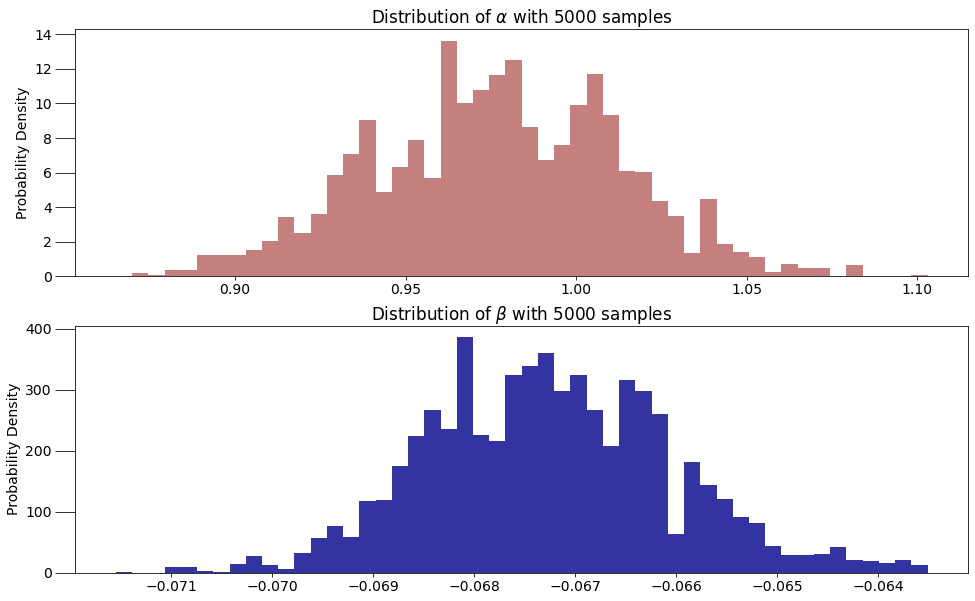

In [16]:
figsize(16, 10)

plt.subplot(211)

plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=50, alpha=0.5, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=50, alpha=0.8, density=True)
plt.ylabel('Probability Density');


If the $\beta$ values were centered around 0 that would indicate time has no effect on the probability of being asleep. The $\alpha$ values also are not at 0, indicating that there is an offset from 10:00 pm in terms of being asleep. I choose to represent the times as an offset from 10:00 PM to avoid dealing with data times as much as possible. 

The spread of the data gives us a measure of uncertainty about the data. A larger spread indicates more uncertainty. As there is considerable overlap in the observations for awake and asleep, the uncertainty is expected to be large. To find the most likely posterior distribution for sleep given the time, we take the average of the $\alpha$ and $\beta$ samples.

## Posterior for Sleep Visualization

In [14]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15)[:, None] # create column axis with lenght 1  

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

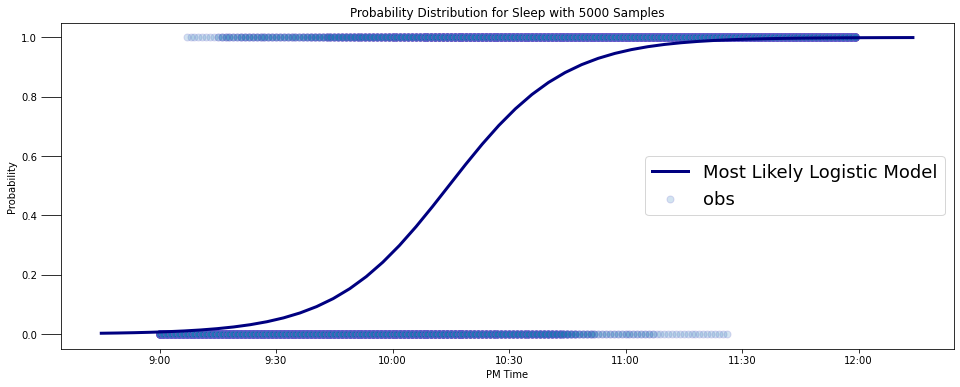

In [15]:
figsize(16, 6)

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="Most Likely Logistic Model")

plt.scatter(time, sleep_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Probability Distribution for Sleep with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probability')
plt.xlabel('PM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

The posterior probability increases from 0 to 1 as the time gets later. The model is not perfect because of the noise in the data, but it is an adequate approximation based on the observations and can provide useful estimates.

In [16]:
print('The probability of sleep increases to above 50% at 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

The probability of sleep increases to above 50% at 10:14 PM.


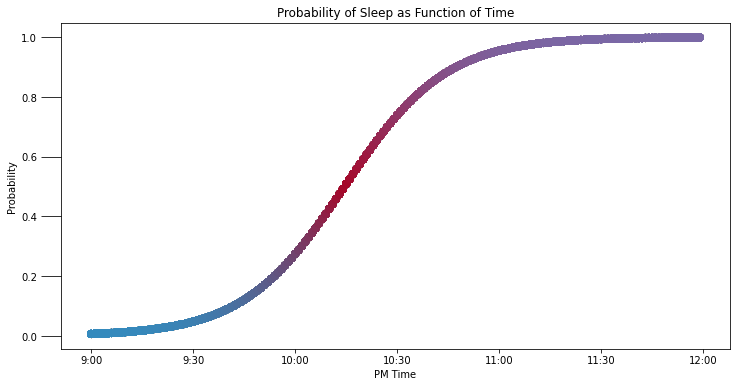

In [17]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('PM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

The posterior can be queried at any time (as an offset from 10:00 PM) to find the probability I am asleep.

In [18]:
print('10:00 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))

print('9:30  PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))

print('10:30 PM probability of being asleep: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM probability of being asleep: 27.42%.
9:30  PM probability of being asleep: 4.80%.
10:30 PM probability of being asleep: 73.88%.


### Confidence Interval

There are many other diagnostics of the model that we can perform. For example, we know there is a considerable amount of uncertainty in our estimates for $\alpha$ and $\beta$. To reflect this in the graph, we can include include the 95% confidence interval at each time based on all of the samples. 

In [19]:
# compute logistic(deterministic) model with our samples 
sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)


# Computes empirical quantiles for data from the sleep distribution
quantiles = stats.mstats.mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

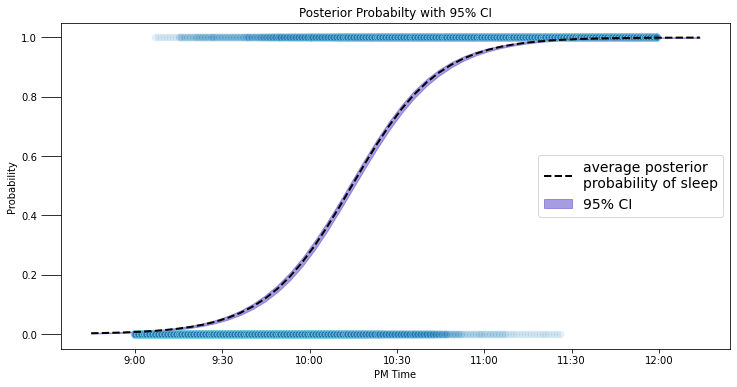

In [20]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% CI')

plt.plot(time_est, sleep_est, lw=2, ls='--', 
         color='black', label="average posterior \nprobability of sleep")

plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels)
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1)
plt.legend(prop={'size':14})
plt.xlabel('PM Time')
plt.ylabel('Probability')
plt.title('Posterior Probabilty with 95% CI');

At each time, there is a measure of uncertainty as to whether or not I am asleep. This represents the fact that MCMC does not return the True parameters.

## Posterior Probability Distribution for Specific Time

We can also plot the posterior distribution of sleep at a time as a histogram based on all of the samples for the paramters. This gives us another look at the uncertainty in the model. 

In [21]:
def sleep_posterior(time_offset, time):
    figsize(16, 8)
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('Probability Distribution for Sleep at %s PM' % time)
    plt.xlabel('Probability of Sleep');
    plt.ylabel('Samples')
    plt.show();

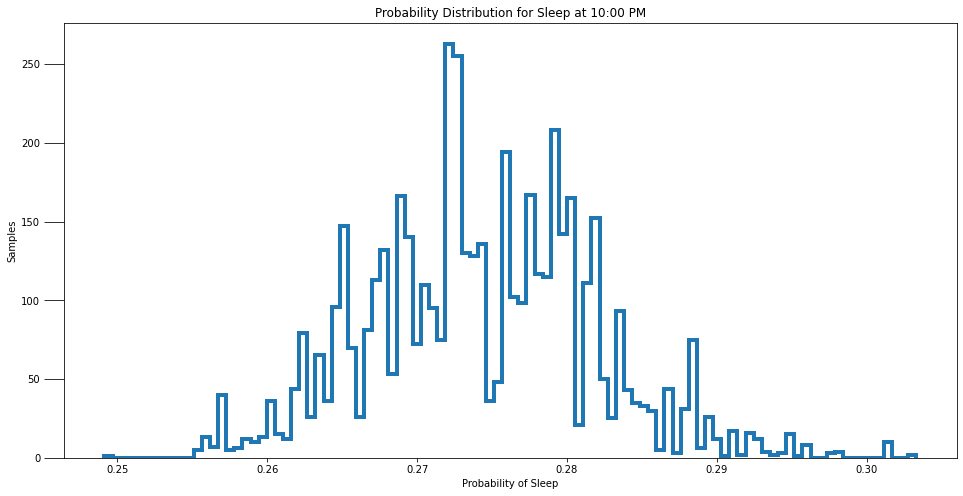

In [22]:
sleep_posterior(0, '10:00')

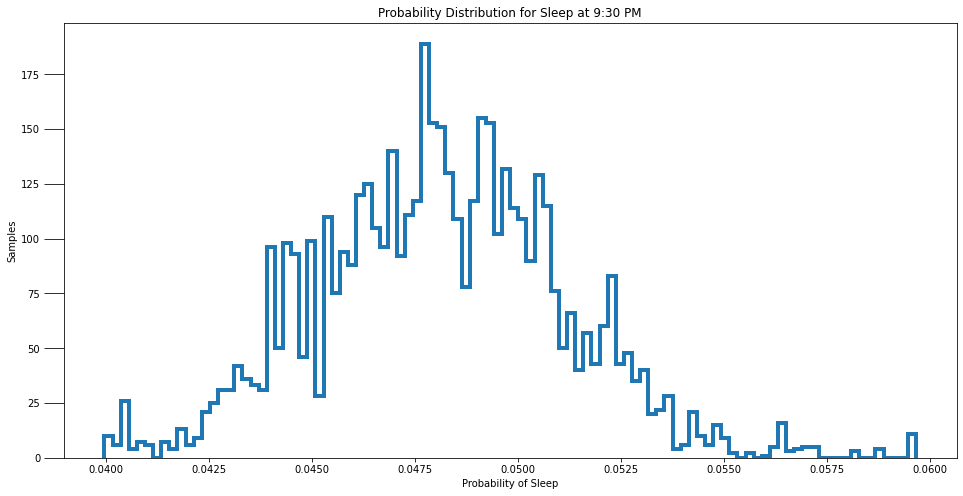

In [23]:
sleep_posterior(-30, '9:30')

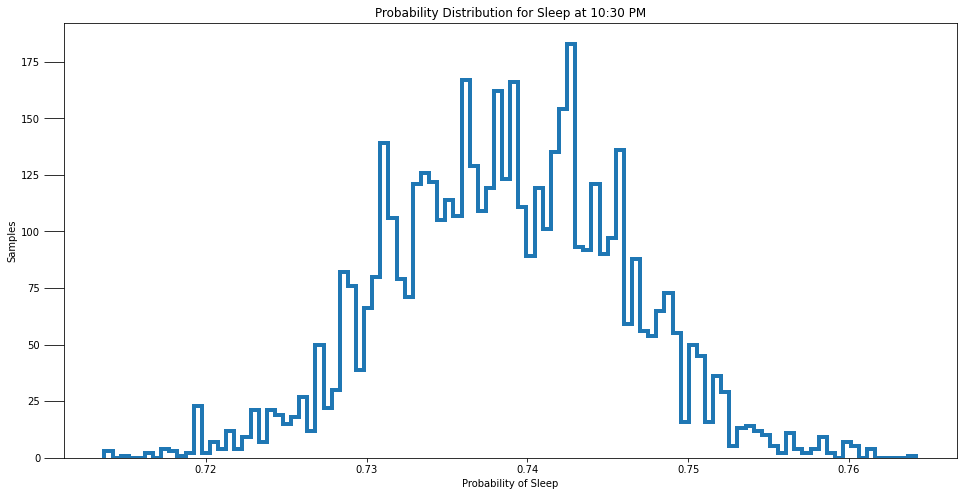

In [24]:
sleep_posterior(30, '10:30')

In [25]:
print('Most likely alpha parameter: {:.6f}.'.format(alpha_est))
print('Most likely beta  parameter: {:.6f}.'.format(beta_est))

Most likely alpha parameter: 0.973557.
Most likely beta  parameter: -0.067105.


## Convergence in Markov Chain Monte Carlo

How can we know if the model converged? We can look at the trace, or the path of the values over sampling. Another option is to look at the auto-correlation of the samples. In Markov Chain modeling, the samples are correlated with themselves because the next value depends on the current state (or the current state and past states based on the order). Initially, the algorithm tends to wander about the search space and will have a high auto-correlation. As the algorithm converges, the samples will settle down around a value and one measure of convergence is a low auto-correlation. We will not do a rigorous study of convergence in this report, but we can plot the traces of all the samples.

## Trace Plots

The plots below show all the samples of $\alpha$ and $\beta$ from the algorithm.

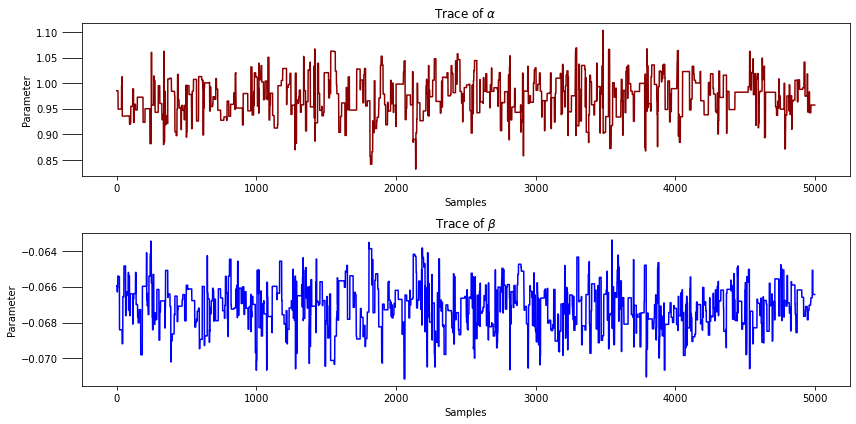

In [26]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)


### Built in Diagnostics

PyMC3 has many built-in diagnostics for model evaluation. Here are the trace plot and autocorrelation plots. 

C:\Users\iveli\anaconda3\envs\mypm3env\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


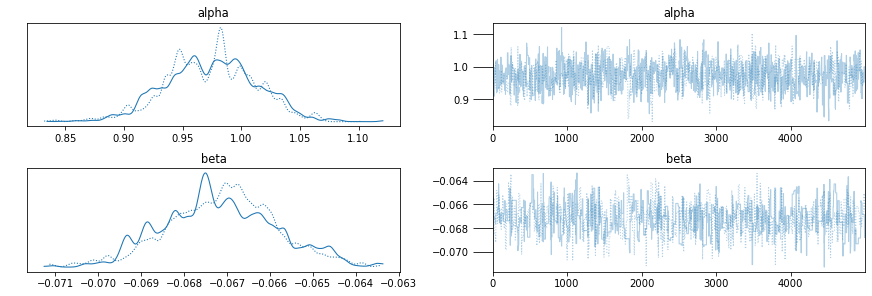

In [27]:
figsize(20, 12)
#coords = {'school': ['Choate', 'Lawrenceville']}
az.plot_trace(sleep_trace, var_names=['alpha', 'beta']);#, filter_vars="like", coords=coords)

#pm.traceplot(sleep_trace, ['alpha', 'beta']);

C:\Users\iveli\anaconda3\envs\mypm3env\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


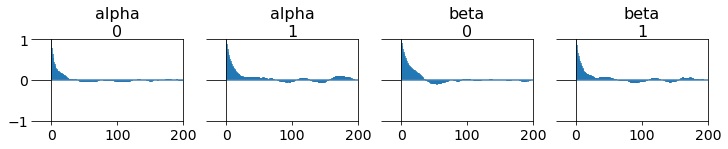

In [28]:
az.plot_autocorr(sleep_trace, ['alpha', 'beta'], max_lag=200, figsize= (10,2));

#pm.autocorrplot(sleep_trace, ['alpha', 'beta']);

# Wake Model

We can repeat the same procedure to find a model for the wake data. 

In [29]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(wake_data.loc[:, 'indicator'])

with pm.Model() as wake_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    wake_trace = pm.sample(N_SAMPLES, step=step)# , njobs=2);

C:\Users\iveli\anaconda3\envs\mypm3env\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 78 seconds.
The number of effective samples is smaller than 10% for some parameters.


## Visualize Posterior for Wake given Time

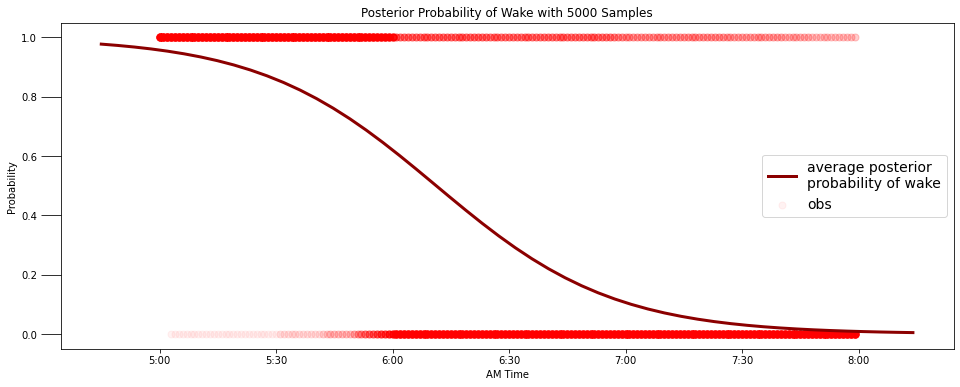

In [30]:
# Extract the alpha and beta samples
alpha_samples = wake_trace["alpha"][5000:, None]
beta_samples = wake_trace["beta"][5000:, None]

# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(16, 6)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="average posterior \nprobability of wake")
plt.scatter(time, wake_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='obs')
plt.title('Posterior Probability of Wake with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probability')
plt.xlabel('AM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

The model does not have a steep transition, which is what I expected because I tend to wake up right around 6:00 AM. There were several times when I woke up several hours later which shifted the curve to the right. 

In [31]:
print('The probability of being awake passes 50% at 6:{} AM.'.format(int(time_est[np.where(wake_est < 0.5)][0])))

The probability of being awake passes 50% at 6:14 AM.


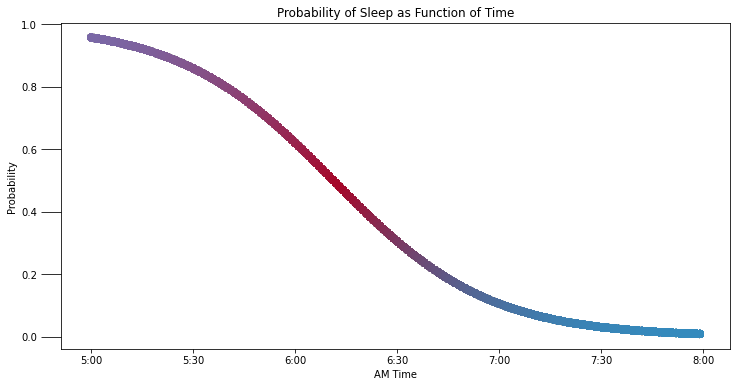

In [32]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = wake_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('AM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

## Investigate the Wake Model

In [33]:
print('Probability of being awake at 5:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(-30, beta=beta_est, alpha=alpha_est))))
print('Probability of being awake at 6:00 AM: {:.2f}%.'.
      format(100 - (100 * logistic(0, beta=beta_est, alpha=alpha_est))))
print('Probability of being awake at 6:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(30, beta=beta_est, alpha=alpha_est))))

Probability of being awake at 5:30 AM: 14.13%.
Probability of being awake at 6:00 AM: 37.94%.
Probability of being awake at 6:30 AM: 69.45%.


# Model for Sleep Duration

We can also form a model to estimate the most likely length of time I am asleep. We can first look at the data and then determine which function fits the probability distribution. 

In [34]:
raw_data = pd.read_csv('data/sleep_wake.csv')
raw_data['length'] = 8 - (raw_data['Sleep'] / 60) + (raw_data['Wake'] / 60)
duration = raw_data['length']

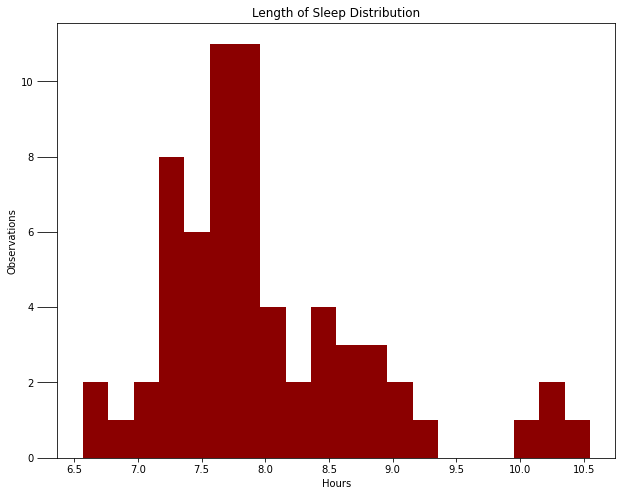

In [35]:
figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred')
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution'); 
plt.ylabel('Observations');

The distribution is skewed to the right. Therefore, we can used a skewed distribution to model the length of sleep. We might also want to use a bi-modal distribution because there appear to be two modes. For now, I will stick to representing the length of sleep distribution as a skewed normal. A skewed normal distribution is shown below. 

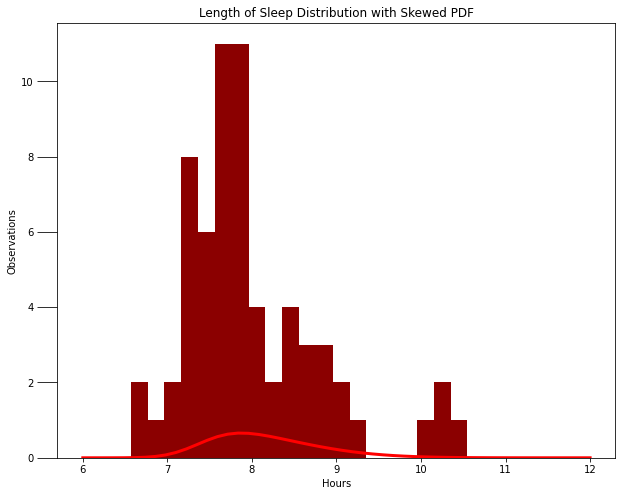

In [36]:
a = 3
fig, ax = plt.subplots(1, 1)
x = np.linspace(6, 12)


figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred')#, normed=True)
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution with Skewed PDF'); 
plt.ylabel('Observations');
plt.plot(x, stats.skewnorm.pdf(x, a, loc = 7.4, scale=1), 'r-', 
         lw=3, label='skewnorm pdf');

In [37]:
with pm.Model() as duration_model:
    # Three parameters to sample
    alpha_skew = pm.Normal('alpha_skew', mu=0, tau=0.5, testval=3.0)
    mu_ = pm.Normal('mu', mu=0, tau=0.5, testval=7.4)
    tau_ = pm.Normal('tau', mu=0, tau=0.5, testval=1.0)
    
    # Duration is a deterministic variable
    duration_ = pm.SkewNormal('duration', alpha = alpha_skew, mu = mu_, 
                              sd = 1/tau_, observed = duration)
    
    # Metropolis Hastings for sampling
    step = pm.Metropolis()
    duration_trace = pm.sample(N_SAMPLES, step=step)
    

C:\Users\iveli\anaconda3\envs\mypm3env\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu]
>Metropolis: [alpha_skew]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 26 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [38]:
# Extract the most likely estimates from the sampling
alpha_skew_samples = duration_trace['alpha_skew'][5000:]
mu_samples = duration_trace['mu'][5000:]
tau_samples = duration_trace['tau'][5000:]

alpha_skew_est = alpha_skew_samples.mean()
mu_est = mu_samples.mean()
tau_est = tau_samples.mean()

## Visualize Posterior Distribution for Sleep Duration

The most likely duration of sleep is 7.66 hours.


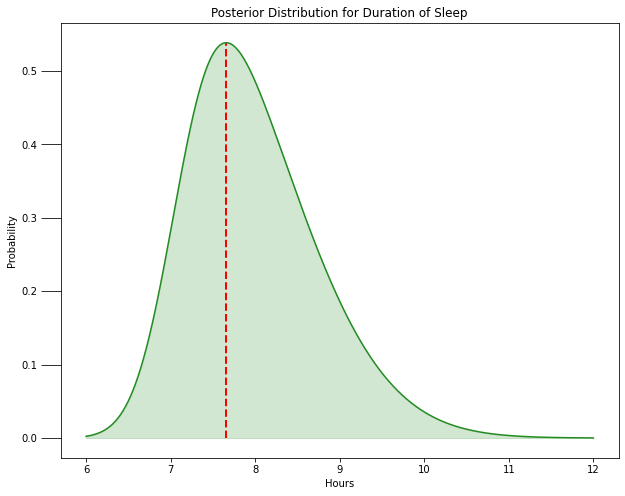

In [39]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
plt.plot(x, y, color = 'forestgreen')
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);
plt.xlabel('Hours'); plt.ylabel('Probability'); 
plt.title('Posterior Distribution for Duration of Sleep');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='red', 
           label = 'Most Likely Duration');

print('The most likely duration of sleep is {:.2f} hours.'.format(x[np.argmax(y)]))

### Query the Posterior Model

In [40]:
print('Probability of at least 6.5 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(6.5, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 8.0 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(8.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probability of at least 9.0 hours of sleep = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(9.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))

Probability of at least 6.5 hours of sleep = 99.10%.
Probability of at least 8.0 hours of sleep = 44.40%.
Probability of at least 9.0 hours of sleep = 11.18%.


## Visualize the Posterior and the Data

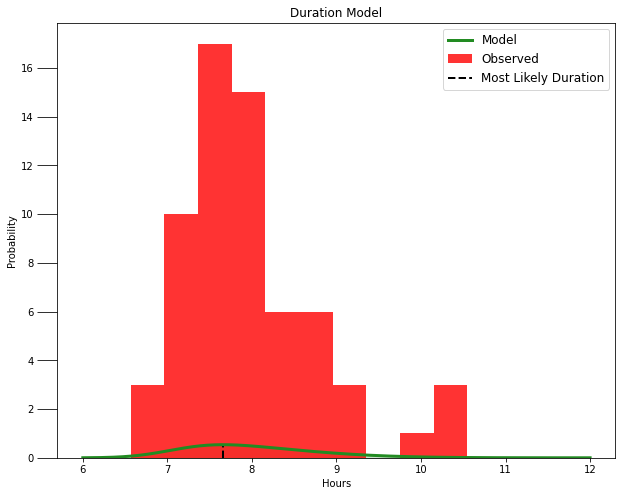

In [41]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
figsize(10, 8)
# Plot the posterior distribution
plt.plot(x, y, color = 'forestgreen', 
         label = 'Model', lw = 3)
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);

# Plot the observed values
plt.hist(duration, bins=10, color = 'red', alpha=0.8,
         label='Observed')#, normed=True)
plt.xlabel('Hours'); plt.ylabel('Probability'); 
plt.title('Duration Model');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='k', 
           label = 'Most Likely Duration');
plt.legend(prop={'size':12});

The posterior skewed normal distribution looks to fit the data well. However, the data may be better modeled as two separate distributions given the second mode to the right. The second mode is not captured in a single skewed normal distribution. Overall, this model still provides a reasonable estimate for the probabilty of duration of my sleep. 

# Conclusions

Based on the observations, we can state the following: 

* __On average I fall asleep by 10:14 PM__
* __On average I wake up by 6:11 AM__
* __My average duration of sleep is 7.67 hours__
    
The models have already provided me with knowledge about my sleeping patterns, and more data would only improve the applicability. I could incorporate additional information such as day of the week or daily activities to see how they affect my sleep and then make adjustments as required. Although this report made several assumptions and did not fully investigate the models, it was a great start towards analyzing actual data with Bayesian methods. Projects, especially with real applications, are the best way to learn, and I look forward to applying Bayesian methods to additional problems! 